In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

In [2]:
# Add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [3]:
# Training set
df = pd.read_csv("NSL_KDD_Train.csv", header=None, names=col_names)
# Testing set
df_test_21 = pd.read_csv("NSL_KDD_Test_21.csv", header=None, names=col_names)

In [4]:
print('Dimensions of the Training set:', df.shape)
print('Dimensions of the Test_21 set:', df_test_21.shape)

# Sample a subset of the data to reduce size
df = df.sample(frac=0.1, random_state=42)  # Use 10% of the original training data
df_test_21 = df_test_21.sample(frac=0.1, random_state=42)  # Use 10% of the original testing data

Dimensions of the Training set: (125973, 42)
Dimensions of the Test_21 set: (11850, 42)


In [5]:
# Drop rows with null values
df.dropna(inplace=True)
df_test_21.dropna(inplace=True)

# Columns that are categorical
categorical_columns = ['protocol_type', 'service', 'flag']

# One-Hot Encoding for categorical columns
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test_21[categorical_columns]

In [6]:
# Apply LabelEncoder to categorical columns
df_categorical_values_enc = df_categorical_values.apply(LabelEncoder().fit_transform)
testdf_categorical_values_enc = testdf_categorical_values.apply(LabelEncoder().fit_transform)

In [7]:
# One-Hot Encode
enc = OneHotEncoder(categories='auto', sparse_output=False)
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
testdf_categorical_values_encenc = enc.transform(testdf_categorical_values_enc)

In [8]:
# Create DataFrame for the encoded categorical values
df_cat_data = pd.DataFrame(df_categorical_values_encenc, columns=enc.get_feature_names_out(categorical_columns))
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc, columns=enc.get_feature_names_out(categorical_columns))

In [9]:
# Combine the encoded categorical values with the original dataframe
df.reset_index(drop=True, inplace=True)
testdf_cat_data.reset_index(drop=True, inplace=True)

In [10]:
newdf = df.join(df_cat_data).drop(columns=categorical_columns)
newdf_test = df_test_21.join(testdf_cat_data).drop(columns=categorical_columns)

# Logarithmic scaling for specific columns
newdf['log2_duration'] = np.log2(newdf['duration'] + 1)
newdf['log_src_bytes'] = np.log(newdf['src_bytes'] + 1)
newdf['log_dst_bytes'] = np.log(newdf['dst_bytes'] + 1)

newdf_test['log2_duration'] = np.log2(newdf_test['duration'] + 1)
newdf_test['log_src_bytes'] = np.log(newdf_test['src_bytes'] + 1)
newdf_test['log_dst_bytes'] = np.log(newdf_test['dst_bytes'] + 1)

# Drop the original columns after scaling
newdf.drop(columns=['duration', 'src_bytes', 'dst_bytes'], inplace=True)
newdf_test.drop(columns=['duration', 'src_bytes', 'dst_bytes'], inplace=True)

In [11]:
# Label mapping
label_mapping = {
    'normal': 0,
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1, 'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

In [12]:
newdf['label'] = newdf['label'].map(label_mapping)
newdf_test['label'] = newdf_test['label'].map(label_mapping)

# Split features and labels
x = newdf.drop(columns=['label'])
y = newdf['label']
xtest = newdf_test.drop(columns=['label'])
ytest = newdf_test['label']

In [13]:
# Multi-class classification using RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold

In [14]:
# Define RNN model
def rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(x.shape[1], 1), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
# Reshape the input data for RNN
x_rnn = np.expand_dims(x, axis=2)
xtest_rnn = np.expand_dims(xtest, axis=2)

# Convert labels to categorical
y_categorical = to_categorical(y)
ytest_categorical = to_categorical(ytest)

In [16]:
# Create KerasClassifier
estimator = KerasClassifier(model=rnn_model, epochs=50, batch_size=32, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
# Evaluate model with cross-validation
results = cross_val_score(estimator, x_rnn, y_categorical, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean() * 100))  

In [18]:
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [19]:
# Split the data by attack type
to_drop_DoS = [0, 1]
to_drop_Probe = [0, 2]
to_drop_R2L = [0, 3]
to_drop_U2R = [0, 4]

In [20]:
DoS_df = newdf[newdf['label'].isin(to_drop_DoS)]
DoS_df_test = newdf_test[newdf_test['label'].isin(to_drop_DoS)]

# Split dataframes into X & Y
X_DoS = DoS_df.drop('label', axis=1)
Y_DoS = DoS_df['label']
X_DoS_test = DoS_df_test.drop('label', axis=1)
Y_DoS_test = DoS_df_test['label']

In [21]:
# Feature scaling
scaler1 = StandardScaler().fit(X_DoS)
X_DoS = scaler1.transform(X_DoS)
X_DoS_test = scaler1.transform(X_DoS_test)

In [22]:
imputer = SimpleImputer(strategy='mean')
X_DoS_imputed = imputer.fit_transform(X_DoS)
X_DoS_test_imputed = imputer.transform(X_DoS_test)

In [23]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_DoS_scaled = scaler.fit_transform(X_DoS_imputed)
X_DoS_test_scaled = scaler.transform(X_DoS_test_imputed)


In [24]:
# Build and evaluate models
models = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", max_depth=3),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "MLP": MLPClassifier(solver='adam', learning_rate_init=0.0005, learning_rate='adaptive', activation="relu", max_iter=2000, random_state=42),
    "SVM": SVC(random_state=1),
    "Naive Bayes": GaussianNB()
}

In [25]:
scores = {}

for key, model in models.items():
    model.fit(X_DoS_scaled, Y_DoS.astype(int))
    Y_pred = model.predict(X_DoS_test_scaled)
    scores[key] = accuracy_score(Y_DoS_test, Y_pred)

# Results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0, ascending=False, inplace=True)
print("Accuracy scores on DoS Test Set:")
print(scores_frame)

Accuracy scores on DoS Test Set:
               Accuracy Score
Naive Bayes          0.670229
MLP                  0.668702
SVM                  0.641221
Random Forest        0.592366
Decision Tree        0.552672


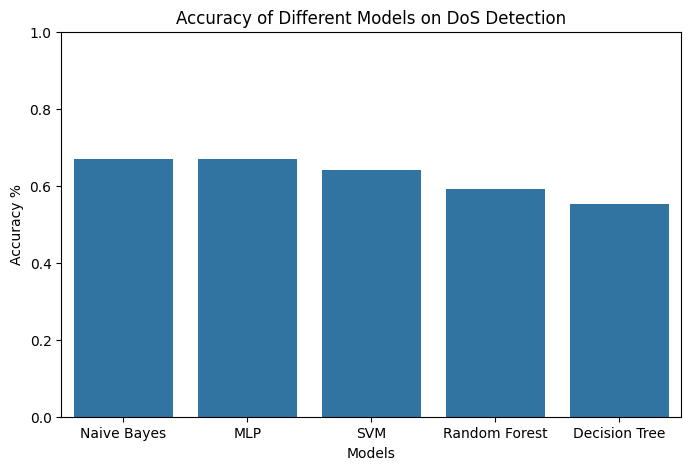

In [26]:
# Plotting the results
plt.figure(figsize=(8, 5))
sns.barplot(x=scores_frame.index, y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy %")
plt.xlabel("Models")
plt.title("Accuracy of Different Models on DoS Detection")
plt.show()

In [27]:
nan_indices = np.isnan(xtest_rnn)
nan_count = np.sum(nan_indices)

In [28]:
xtest_rnn[np.isnan(xtest_rnn)] = 0


In [29]:
# Assuming xtest_rnn is a 3-dimensional array, you might need to reshape it back temporarily
nan_rows = np.any(np.isnan(xtest_rnn), axis=(1, 2))  # Check for NaN across all dimensions
xtest_rnn_clean = xtest_rnn[~nan_rows]

In [30]:
# Fit the model
estimator.fit(x_rnn, y_categorical)

# Predictions on test set
y_pred = estimator.predict(xtest_rnn)

# Convert predictions back from categorical to labels
y_pred_labels = np.argmax(y_pred, axis=1)
ytest_labels = np.argmax(ytest_categorical, axis=1)

# Print classification report
print(classification_report(ytest_labels, y_pred_labels))

C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


              precision    recall  f1-score   support

           0       0.32      0.79      0.46       214
           1       0.55      0.62      0.58       441
           2       0.40      0.16      0.23       247
           3       0.50      0.10      0.17       277
           4       0.00      0.00      0.00         6

    accuracy                           0.43      1185
   macro avg       0.35      0.34      0.29      1185
weighted avg       0.46      0.43      0.39      1185



C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test Accuracy: 82.8%
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.31      0.76      0.44       214
           1       0.44      0.20      0.27       441
           2       0.40      0.68      0.50       247
           3       0.76      0.12      0.20       277
           4       0.00      0.00      0.00         6

    accuracy                           0.38      1185
   macro avg       0.38      0.35      0.28      1185
weighted avg       0.48      0.38      0.33      1185



C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ARP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

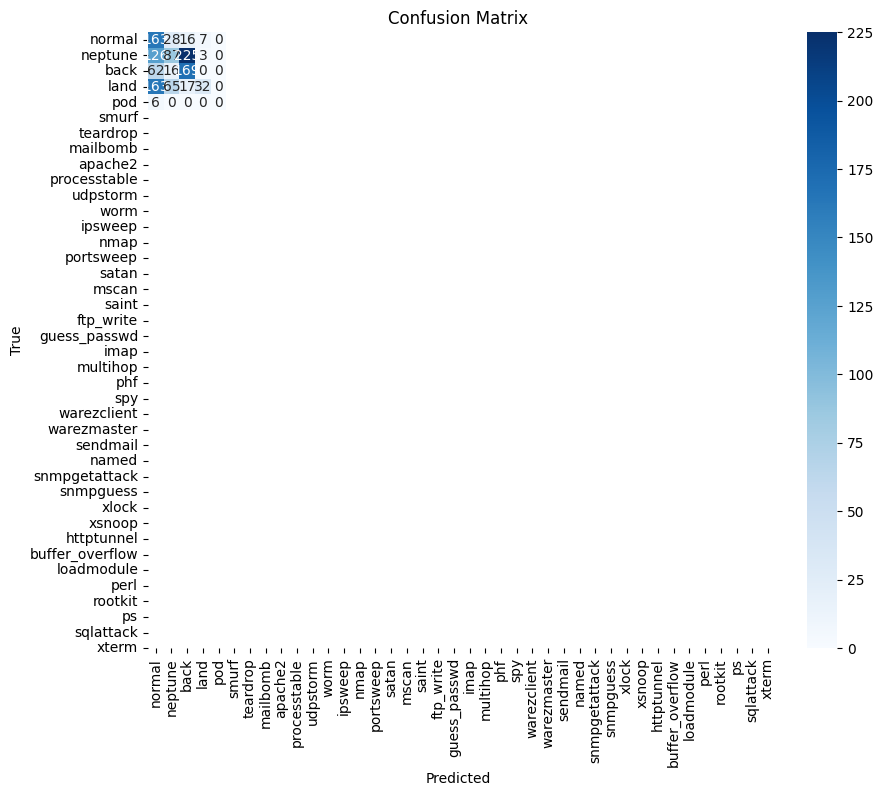

In [33]:
# Train the model on the entire training data
model = rnn_model()
model.fit(x_rnn, y_categorical, epochs=50, batch_size=32, verbose=0)

# Evaluate on the testing data
test_loss, test_accuracy = model.evaluate(xtest_rnn, ytest_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Predict labels for the testing data
y_pred = model.predict(xtest_rnn)

# Convert categorical labels back to original form (if needed)
y_pred_labels = np.argmax(y_pred, axis=1)
ytest_labels = np.argmax(ytest_categorical, axis=1)

# Generate and print classification report
print(classification_report(ytest_labels, y_pred_labels))

# Draw confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(ytest_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()